In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
#from grids import *
from docking_analysis import *

/home/enf/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
import io_functions
from imp import reload
reload(io_functions)
from io_functions import *

In [6]:
from operator import itemgetter

In [7]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [8]:
from detect_intermediates import *
from interpret_tICs import *

we are operating on biox3


In [10]:
from get_variable_names import *
inactive_dir = "/home/enf/md_simulations/b2ar/reference_receptors/2RH1_prepped-A.pdb"
active_dir = "/home/enf/md_simulations/b2ar/reference_receptors/3P0G_pymol_prepped-A.pdb"
simulation_structure = "/home/enf/md_simulations/b2ar/reference_receptors/ionized.pdb"
common_residues_pkl = "/home/enf/md_simulations/b2ar/reference_receptors/common_residues.pkl"
contact_residues = find_common_residues([inactive_dir, active_dir, simulation_structure], common_residues_pkl)

[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 265, 266, 267, 268, 269, 270, 271, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282

In [13]:
exacycle = False


n_clusters = 300
lag_time = 5
if exacycle:
  lag_time *= 2

msm_lag_time = 5
n_components = 10
n_samples = 10
n_macrostates = 25
n_trees = 100

precision = "SP"

sparse = True
wolf = True

is_sparse = ""
if(sparse): is_sparse = "sparse-"

shrinkage_string = ""
rho_string = ""
if wolf and not sparse:
  wolf_string = "_wolf_"
  shrinkage = None
  shrinkage_string = "autoShrinkage"
  rho = None
  rho_string = ""
elif wolf and sparse:
  wolf_string = "_wolf_"
  shrinkage = None
  shrinkage_string = "autoShrinkage"
  rho = 0.005
  rho_string = "_rho0pt005"
else:
  wolf_string = ""
  shrinkage = 0.001
  shrinkage_string = "0pt001"
  rho = None
  rho_string = ""

traj_ext = ".h5"
base = "/home/enf/md_simulations/b2ar/Salmeterol"
traj_dir = "/home/enf/md_simulations/b2ar/Salmeterol/h5_trajectories"
structure = None
iterative = False
featurize_parallel = True

sampling_method = "random"
precision = "SP"



In [14]:
feature_name = "contacts_within_6pt6_angstroms"
ori_feature_name = copy.deepcopy(feature_name)

NameError: name 'feature_name' is not defined

In [7]:
rho = 0.1
rho_string = "0pt1"
lag_time = 5
n_components = 10
n_clusters = 1500

rho = 0.01
rho_string = "0pt01"
lag_time=50
ori_feature_name = copy.deepcopy(feature_name)

In [8]:
schemes = ["closest-heavy", "CA"]
feature_name = "%s-CA-py3-far" %ori_feature_name
#feature_name = "%s_phi_psi_chi2" %feature_name
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
#tica_dir = "%s-with-inactive" %tica_dir
tica_dir = "%s-backup" %tica_dir
ori_tica_dir = copy.deepcopy(tica_dir)
#tica_dir = "%s-normalized" % ori_tica_dir
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far
/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far


In [9]:
features_dir

'/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far'

In [10]:
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

208


<AsyncMapResult: chdir>

In [106]:
import custom_featurizer
reload (custom_featurizer)
from custom_featurizer import *
f338a_trajectories = [t for t in get_trajectory_files(traj_dir, ".h5") if "f338a" in t]
fix_chain_names(f338a_trajectories, None)
#featurize_contacts_custom(traj_dir, features_dir = features_dir, traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, structures=[inactive_dir, active_dir], contact_residues=contact_residues,
#                          residues_map = None, contact_cutoff = cutoff, parallel = False, exacycle = exacycle, traj_top_structure = None, iterative=False,
#                          user_specified_atom_residue_pairs = [], load_from_file=False, worker_pool=None, schemes=schemes)

In [107]:
user_defined_features_dir = "%s/user_defined_features" %traj_dir
if not os.path.exists(user_defined_features_dir):
    os.makedirs(user_defined_features_dir)
compute_user_defined_features_wrapper(traj_dir, traj_ext, inactive_dir, active_dir, None,
                                        feature_name_residues_dict, user_defined_features_file, worker_pool=None, 
                                        save_dir=user_defined_features_dir, parallel=True, overwrite=False)

save_file = /home/enf/md_simulations/MOR/h8_reimaged/trajectories/user_defined_features/apo_rep_17.dataset
save_file = /home/enf/md_simulations/MOR/h8_reimaged/trajectories/user_defined_features/apo_rep_1.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/trajectories/user_defined_features/apo_rep_17.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/trajectories/user_defined_features/apo_rep_1.dataset
save_file = /home/enf/md_simulations/MOR/h8_reimaged/trajectories/user_defined_features/apo_rep_134.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/trajectories/user_defined_features/apo_rep_134.dataset
save_file = /home/enf/md_simulations/MOR/h8_reimaged/trajectories/user_defined_features/apo_rep_44.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/trajectories/user_defined_features/apo_rep_44.dataset
save_file = /home/enf/md_simulations/MOR/h8_reimaged/trajectories/user_defined_features/apo_reseeded_rep_114.dataset
loading /home/enf/md_simulations/MOR/h8_rei

In [ ]:
ref_user_defined_features_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5"
ref_user_defined_features_dir = "%s/ref_user_defined_features" %traj_dir
if not os.path.exists(ref_user_defined_features_dir):
    os.makedirs(ref_user_defined_features_dir)

compute_user_defined_features_wrapper(ref_receptors_dir, ".pdb", inactive_dir, active_dir, None,
                                        feature_name_residues_dict, ref_user_defined_features_file, worker_pool=None, 
                                        save_dir=ref_user_defined_features_dir, parallel=False, overwrite=True)

In [11]:
traj_dir = "/home/enf/md_simulations/MOR/h8_reimaged/trajectories"

In [108]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
featurize_contacts_custom(traj_dir, features_dir = features_dir, traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, structures=[inactive_dir, active_dir], contact_residues=contact_residues,
                          residues_map = None, contact_cutoff = cutoff, parallel = False, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs = [], load_from_file=False, worker_pool=None, schemes=schemes, binarize=None, redo=False, within_turn=False)

already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already feat

In [ ]:
fit_normalizer(features_dir)

In [12]:
import pickle
with open(feature_residues_pkl, "rb") as f:
    feature_residues = pickle.load(f)

In [13]:
[(feature_residues[i], i) for i in range(0,len(feature_residues)) if "TRP293" in str(feature_residues[i])]

[(ALA240 to TRP293, 104),
 (ASN150 to TRP293, 259),
 (ASN328 to TRP293, 304),
 (ASN332 to TRP293, 320),
 (ASP147 to TRP293, 366),
 (CYS321 to TRP293, 457),
 (GLY325 to TRP293, 534),
 (ILE155 to TRP293, 628),
 (ILE298 to TRP293, 713),
 (ILE322 to TRP293, 727),
 (LEU158 to TRP293, 794),
 (LEU324 to TRP293, 855),
 (MET151 to TRP293, 928),
 (PHE152 to TRP293, 1000),
 (PHE241 to TRP293, 1023),
 (SER154 to TRP293, 1080),
 (SER329 to TRP293, 1104),
 (TRP293 to TYR326, 1166),
 (TRP293 to VAL288, 1167),
 (ALA240_CA to TRP293_CA, 1308),
 (ASN150_CA to TRP293_CA, 1463),
 (ASN328_CA to TRP293_CA, 1508),
 (ASN332_CA to TRP293_CA, 1524),
 (ASP147_CA to TRP293_CA, 1570),
 (CYS321_CA to TRP293_CA, 1661),
 (GLY325_CA to TRP293_CA, 1738),
 (ILE155_CA to TRP293_CA, 1832),
 (ILE298_CA to TRP293_CA, 1917),
 (ILE322_CA to TRP293_CA, 1931),
 (LEU158_CA to TRP293_CA, 1998),
 (LEU324_CA to TRP293_CA, 2059),
 (MET151_CA to TRP293_CA, 2132),
 (PHE152_CA to TRP293_CA, 2204),
 (PHE241_CA to TRP293_CA, 2227),
 (SER

In [ ]:
import custom_tica
reload(custom_tica)
from custom_tica import *
fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True, partial_fit=True)

In [123]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *

featurize_contacts_custom(ref_receptors_dir, features_dir = ref_features_dir, traj_ext = ".pdb", contact_residue_pairs_file = feature_residues_pkl, structures=[inactive_dir, active_dir], contact_residues=contact_residues,
                          residues_map = None, contact_cutoff = cutoff, parallel = False, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs = [], load_from_file=False, worker_pool=None, schemes=schemes, within_turn=False, binarize=None, redo=False)

already featurized
already featurized
structure
/home/enf/md_simulations/MOR/4dkl_R_for_conformation.pdb
structure
None
mdraj_index_combinations[0:10]
[(41, 73), (41, 114), (41, 108), (41, 248), (41, 166), (41, 84), (41, 13), (41, 76), (41, 74), (41, 18)]
contact_features[0:10]
[[TYR106, ILE138], [TYR106, ARG179], [TYR106, VAL173], [TYR106, HIS319], [TYR106, LEU231], [TYR106, TYR149], [TYR106, VAL78], [TYR106, LYS141], [TYR106, LEU139], [TYR106, LEU83]]
About to compute 35255 features
(1, 35255)
cutoff
0.66
distances[0:10]
[[ 2.53460574  0.61586297  1.52706683 ...,  1.51371932  3.94720888
   2.2300899 ]]
There are 955 residue-residue contacts below cutoff in structure.
structure
/home/enf/md_simulations/MOR/5c1m.pdb
structure
None
mdraj_index_combinations[0:10]
[(54, 86), (54, 127), (54, 121), (54, 267), (54, 179), (54, 97), (54, 26), (54, 89), (54, 87), (54, 31)]
contact_features[0:10]
[[TYR106, ILE138], [TYR106, ARG179], [TYR106, VAL173], [TYR106, HIS319], [TYR106, LEU231], [TYR106, 

In [124]:
transform(existing_model = projection_operator_dir, features_directory = ref_features_dir, tica_dir = ref_tica_dir, normalizer=compat_verboseload("%s/normalizer.h5" %features_dir))


loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/phi_psi_chi2_allprot_tica_coords.h5"...
None
None
['/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/4dkl_R_for_conformation.dataset', '/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/5c1m.dataset']
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/5c1m.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/4dkl_R_for_conformation.dataset


In [ ]:
import custom_tica
reload(custom_tica)
from custom_tica import *
transform_to_h5(projection_operator_dir, features_dir, projected_features_dir, worker_pool=None, parallel=True, normalizer=compat_verboseload("%s/normalizer.h5" %features_dir))

In [14]:
tica_object = compat_verboseload(projection_operator_dir)

In [15]:
with open(projection_operator_dir, 'rb') as f:
    tica_object = pickle.load(f, encoding='latin1') 

In [20]:
#all_tica = compat_verboseload(projected_features_dir)
#all_tica = [x[:,range(1,10)] for x in all_tica]
#print(all_tica[0].shape)
#print(len(all_tica))
#verbosedump(all_tica, projected_features_dir)


In [21]:
#n_components=9

In [16]:
tica_object.timescales_

array([ 1655.96224959,  1078.68106057,   797.08171757,   716.45590377,
         658.99925169,   454.42244334,   372.47408422,   370.3421338 ,
         365.56500232,   353.28358375])

In [ ]:
plot_columns(tica_dir, projected_features_dir, titles = ["tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

In [17]:
feature_indices = []
traj_basenames = get_trajectory_files(traj_dir, ".h5")
traj_basenames = [os.path.splitext(os.path.basename(t))[0] for t in traj_basenames]
feature_basenames = get_trajectory_files(features_dir, ".dataset")
feature_basenames = [os.path.splitext(os.path.basename(t))[0] for t in feature_basenames]
for i, traj_basename in enumerate(traj_basenames):
    if traj_basename in feature_basenames:
        feature_indices.append(int(i))

In [18]:
tica_coords = compat_verboseload(projected_features_dir)
pnas_coords = compat_verboseload(user_defined_features_file)
pnas_coords = [pnas_coords[i] for i in feature_indices]
tica_names = ["tIC.%d" %i for i in range(1,n_components+1)]
pnas_names = sorted(feature_name_residues_dict.keys())

In [19]:
print(np.concatenate(tica_coords).shape)
print(np.concatenate(pnas_coords).shape)

(755979, 10)
(738927, 15)


In [ ]:
from plots import *

In [ ]:
plot_data_vs_data(np.concatenate(tica_coords), np.concatenate(pnas_coords), tica_names, pnas_names, analysis_dir)

In [20]:
subsampled_features_dir = os.path.join(tica_dir, "subsampled_features")
if not os.path.exists(subsampled_features_dir): os.makedirs(subsampled_features_dir)

In [21]:
feature_names = compat_verboseload(feature_residues_pkl)

In [22]:
ref_features = [load_file(f) for f in get_trajectory_files(ref_features_dir, ".dataset")]
print(len(ref_features))
print(ref_features[0].shape)
print(ref_features[1].shape)
print(len(feature_names))
ref_features = pd.DataFrame(ref_features[0], columns=[str(f) for f in feature_names])

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/4dkl_R_for_conformation.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/5c1m.dataset
2
(1, 2408)
(1, 2408)
2408


In [23]:
#import interpret_tICs
#reload(interpret_tICs)
#from interpret_tICs import *
tic_components_dir = tica_dir
important_contact_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, feature_residues_pkl, n_tica_components=n_components, percentile=95)


Interpreting tIC 1
feature_importances_df.shape
(10, 5)
residue_importances_df.shape
(12, 2)
             feature_name      res_i      res_j  importance  \
7  Lys233_Ca To Lys303_Ca  Lys233_Ca  Lys303_Ca   -0.380112   
1  Ala304_Ca To Asn230_Ca  Ala304_Ca  Asn230_Ca    0.325877   
2  Ala304_Ca To Lys233_Ca  Ala304_Ca  Lys233_Ca    0.306402   
6  Ile308_Ca To Tyr299_Ca  Ile308_Ca  Tyr299_Ca    0.290794   
5  Ile308_Ca To Trp318_Ca  Ile308_Ca  Trp318_Ca   -0.284625   
3  Ala304_Ca To Tyr299_Ca  Ala304_Ca  Tyr299_Ca   -0.282444   
0        Leu339 To Val334     Leu339     Val334    0.251023   
9  Val236_Ca To Val300_Ca  Val236_Ca  Val300_Ca    0.222654   
4  Ile301_Ca To Val236_Ca  Ile301_Ca  Val236_Ca   -0.214483   
8  Lys303_Ca To Trp318_Ca  Lys303_Ca  Trp318_Ca    0.171570   

                  feature  
7  LYS233_CA to LYS303_CA  
1  ALA304_CA to ASN230_CA  
2  ALA304_CA to LYS233_CA  
6  ILE308_CA to TYR299_CA  
5  ILE308_CA to TRP318_CA  
3  ALA304_CA to TYR299_CA  
0        LEU339 t

In [24]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
tic_subsampled_features_file = "%s/features_subsampled.pkl" % tica_dir
subsampled_features_dir = os.path.join(tica_dir, "subsampled_features")
if not os.path.exists(subsampled_features_dir): os.makedirs(subsampled_features_dir)
important_contact_features_pruned, important_contact_features_indices = find_non_zero_features(important_contact_features[0], feature_names)
if not os.path.exists(tic_subsampled_features_file):
    subsample_features(features_dir, important_contact_features_indices, important_contact_features_pruned, tic_subsampled_features_file)

In [25]:
tic_subsampled_features_file

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/features_subsampled.pkl'

In [26]:
protein_top_features = load_file(tic_subsampled_features_file)
protein_top_features_concat = pd.concat(protein_top_features)

loading /home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/features_subsampled.pkl


In [ ]:
plt.scatter(protein_top_features_concat["LEU158_CA to VAL285_CA"].values[::1000], protein_top_features_concat["PHE289 to TYR336"].values[::1000])
plt.show()

In [ ]:
from ipyparallel import Client
rc = Client()
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

print(len(rc.ids))


In [36]:
bu72_trajs = []
apo_trajs = []
oxy_trajs = []
suf_trajs = []
trv_trajs = []
f338a_trajs = []
trajs = get_trajectory_files(traj_dir, ".h5")
#trajs = [t for t in get_trajectory_files(traj_dir, traj_ext) if "apo_reimaged" not in t and "oxy" not in t]
for i, traj in enumerate(trajs):
    if "bu72" in traj or "CO" in traj or "Co" in traj:
        bu72_trajs.append(i)
    elif "apo" in traj:
        apo_trajs.append(i)
    elif "oxy" in traj:
        oxy_trajs.append(i)
    elif "suf" in traj:
        suf_trajs.append(i)
    elif "trv" in traj:
        trv_trajs.append(i)
    elif "f338a" in traj:
        f338a_trajs.append(i)

user_defined_coords = load_file(user_defined_features_file)

            

loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5


In [28]:
len(f338a_trajs)

58

In [30]:
bu72_pnas = [user_defined_coords[i] for i in bu72_trajs]
apo_pnas = [user_defined_coords[i] for i in apo_trajs]
oxy_pnas = [user_defined_coords[i] for i in oxy_trajs]
suf_pnas = [user_defined_coords[i] for i in suf_trajs]
f338a_pnas = [user_defined_coords[i] for i in f338a_trajs]

In [31]:
bu72_pnas_file = "%s/bu72.h5" % whole_trajectory_pnas
apo_pnas_file = "%s/apo.h5" % whole_trajectory_pnas
#oxy_pnas_file = "%s/oxy.h5" % whole_trajectory_pnas
suf_pnas_file = "%s/suf.h5" % whole_trajectory_pnas
f338a_pnas_file = "%s/f338a.h5" % whole_trajectory_pnas

In [32]:
from imp import reload
import analysis
reload(analysis)
from analysis import *
import seaborn as sns
bu72_pnas_concatenated = np.concatenate(bu72_pnas)
print(np.shape(bu72_pnas_concatenated))
apo_pnas_concatenated = np.concatenate(apo_pnas)
#oxy_pnas_concatenated = np.concatenate(oxy_pnas)
suf_pnas_concatenated = np.concatenate(suf_pnas)
f338a_pnas_concatenated = np.concatenate(f338a_pnas)





verbosedump(bu72_pnas, bu72_pnas_file)
verbosedump(apo_pnas, apo_pnas_file)
#verbosedump(oxy_pnas, oxy_pnas_file)
verbosedump(suf_pnas, suf_pnas_file)
verbosedump(f338a_pnas, f338a_pnas_file)






columns=sorted(feature_name_residues_dict.keys())
#plot_columns(whole_trajectory_pnas, bu72_pnas_file, titles=columns, main = "BU72", tICA = False, scale = 1.0, refcoords_file = None)
#plot_columns(whole_trajectory_pnas, apo_pnas_file, titles=columns, main = "Apo", tICA = False, scale = 1.0, refcoords_file = None)

#df = pd.DataFrame(bu72_pnas_concatenated, columns=sorted(feature_name_residues_dict.keys()))
#sns.jointplot(x="tm6_tm3_dist", y="rmsd_npxxy_inactive", data=df, kind="kde")
#plt.hexbin(bu72_pnas_concatenated[:,0], bu72_pnas_concatenated[:,2], cmap=plt.cm.YlOrRd_r)

(248499, 15)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5"... (<class 'list'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/apo.h5"... (<class 'list'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/suf.h5"... (<class 'list'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/f338a.h5"... (<class 'list'>)


In [37]:
#oxy_tica_file = "%s/oxy_tica.h5" % tica_dir
bu72_tica_file = "%s/bu72_tica.h5" % tica_dir
apo_tica_file = "%s/apo_tica.h5" % tica_dir
suf_tica_file = "%s/suf_tica.h5" % tica_dir

In [38]:
tica_coords = compat_verboseload(projected_features_dir)
#oxy_tica = [tica_coords[i] for i in oxy_trajs]
bu72_tica = [tica_coords[i] for i in bu72_trajs]
apo_tica = [tica_coords[i] for i in apo_trajs]
suf_tica = [tica_coords[i] for i in suf_trajs]


#verbosedump(oxy_tica, oxy_tica_file)
verbosedump(bu72_tica, bu72_tica_file)
verbosedump(apo_tica, apo_tica_file)
verbosedump(suf_tica, suf_tica_file)



columns = ["tIC%d" %i for i in range(1,n_components+1)]
#plot_columns(tica_dir, bu72_tica_file, titles=columns, main = "BU72", tICA = False, scale = 1.0, refcoords_file = None)
#plot_columns(tica_dir, apo_tica_file, titles=columns, main = "Apo", tICA = False, scale = 1.0, refcoords_file = None)




Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_tica.h5"... (<class 'list'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_tica.h5"... (<class 'list'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_tica.h5"... (<class 'list'>)


In [39]:
#print(np.concatenate(oxy_tica).shape)
print(np.concatenate(apo_tica).shape)
print(np.concatenate(bu72_tica).shape)
print(np.concatenate(suf_tica).shape)


(235459, 10)
(248499, 10)
(272021, 10)


In [59]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *
n_clusters = 100
clusterer_dir = "%s/clusterer_%dclusters.h5" %(tica_dir, n_clusters)
if not os.path.exists(clusterer_dir):
    cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters=n_clusters, clusterer_dir=clusterer_dir)

Clustering by KMeans
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/phi_psi_chi2_allprot_projected.h5"...
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/clusterer_100clusters.h5"... (<class 'msmbuilder.cluster.MiniBatchKMeans'>)


In [60]:
print(clusterer_dir)

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/clusterer_100clusters.h5


In [61]:
oxy_clusterer_file = "%s/oxy_clusterer%d.h5" %(tica_dir, n_clusters)
bu72_clusterer_file = "%s/bu72_clusterer%d.h5" %(tica_dir, n_clusters)
apo_clusterer_file = "%s/apo_clusterer%d.h5" %(tica_dir, n_clusters)
suf_clusterer_file = "%s/suf_clusterer%d.h5" %(tica_dir, n_clusters)



In [62]:
clusterer = compat_verboseload(clusterer_dir)
cluster_labels = clusterer.labels_
#oxy_clusters = [cluster_labels[i] for i in oxy_trajs]
bu72_clusters = [cluster_labels[i] for i in bu72_trajs]
apo_clusters = [cluster_labels[i] for i in apo_trajs]
suf_clusters = [cluster_labels[i] for i in suf_trajs]



bu72_clusterer = copy.deepcopy(clusterer)
bu72_clusterer.labels_ = bu72_clusters
#if not os.path.exists(bu72_clusterer_file):
verbosedump(bu72_clusterer, bu72_clusterer_file)

apo_clusterer = copy.deepcopy(clusterer)
apo_clusterer.labels_ = apo_clusters
    
#if not os.path.exists(apo_clusterer_file):
verbosedump(apo_clusterer, apo_clusterer_file)

#oxy_clusterer = copy.deepcopy(clusterer)
#oxy_clusterer.labels_ = oxy_clusters
    
#if not os.path.exists(oxy_clusterer_file):
#verbosedump(oxy_clusterer, oxy_clusterer_file)

suf_clusterer = copy.deepcopy(clusterer)
suf_clusterer.labels_ = suf_clusters
    
#if not os.path.exists(oxy_clusterer_file):
verbosedump(suf_clusterer, suf_clusterer_file)

Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_clusterer100.h5"... (<class 'msmbuilder.cluster.MiniBatchKMeans'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_clusterer100.h5"... (<class 'msmbuilder.cluster.MiniBatchKMeans'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_clusterer100.h5"... (<class 'msmbuilder.cluster.MiniBatchKMeans'>)


In [63]:
cluster_tica_averages = calculate_cluster_averages_per_feature(bu72_clusterer, bu72_tica)
cluster_tica_averages = pd.DataFrame(cluster_tica_averages, columns=["tIC.%d" %i for i in range(1, n_components+1)])



In [64]:
intermediate_actives = cluster_tica_averages.loc[(cluster_tica_averages["tIC.2"] > 0.7) & (cluster_tica_averages["tIC.2"] < 1.2) & (cluster_tica_averages["tIC.5"] > 0.) & (cluster_tica_averages["tIC.2"] < 0.8)]
intermediate_actives

,tIC.1,tIC.2,tIC.3,tIC.4,tIC.5,tIC.6,tIC.7,tIC.8,tIC.9,tIC.10


In [65]:
import custom_msm
reload(custom_msm)
from custom_msm import *
from msm_resampled import *

In [66]:
apo_clusters_map = make_clusters_map(apo_clusterer)
bu72_clusters_map = make_clusters_map(bu72_clusterer)
#oxy_clusters_map = make_clusters_map(oxy_clusterer)
suf_clusters_map = make_clusters_map(suf_clusterer)

3786
5239
0
1540
6118
1123
2304
0
19882
1
168
4332
1
0
14
4305
1451
0
824
1
7569
2104
1988
212
5920
0
834
2732
1667
48
98
30
15785
6980
10
3360
3386
1368
4371
0
2109
1211
4904
32
3116
24
1662
6596
0
310
225
5173
1067
1458
13
0
49
6498
5043
1
765
146
1
1526
3071
325
12411
7735
6012
13414
1946
0
1020
13005
971
8
970
562
0
0
4436
479
7841
0
0
10
13
39
1
104
123
0
538
3472
0
0
5469
1
0
3
16284
16035
0
472
236
791
3077
5579
5182
3610
0
0
2
0
0
251
3662
0
2276
0
37
2134
0
0
3875
3
13544
4382
33
2
350
2
14405
1161
0
11135
8905
71
12
0
0
115
3225
779
2181
17
216
0
0
13
1
2895
64
164
437
4
0
5685
11333
0
5442
3408
0
11
9210
1167
12707
1823
316
5432
196
0
2159
16282
333
0
0
8533
9433
1
1600
150
9448
0
4984
5
78
46
3
0
8
0
2621
4212
0
3
4201
0
0
50
166
1643
7055
6838
392
51
10428
0
739
3
3656
145
2206
3389
7849
324
5331
7722
249
13523
234
306
0
2490
3263
3400
0
243
116
7344
6094
2998
550
132
2258
712
374
1253
2923
1247
0
381
388
3
280
4453
9806
42
4547
990
9968
1034
4582
1621
639
2403
1710
739
23

In [ ]:
plt.clf()
plot_timescales(apo_clusterer_file, n_clusters, tica_dir, main="Apo MSM Timescales", lag_times=list(range(1,51,10)))

In [ ]:
plt.clf()
import custom_msm
reload(custom_msm)
from custom_msm import *
plot_timescales(bu72_clusterer_file, n_clusters, tica_dir, main="BU72 MSM Timescales", lag_times=[1,5,10,15,20])

In [ ]:
plt.clf()
plot_timescales(suf_clusterer_file, n_clusters, tica_dir, main="SUF MSM Timescales", lag_times=list(range(1,51,10)))

In [48]:
import custom_msm
import importlib
importlib.reload(custom_msm)
from custom_msm import *

apo_lag_time=25.
prior_counts = 1e-5
ergodic_cutoff = 'off'
apo_msm_dir = os.path.join(tica_dir, "apo_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(apo_lag_time, str(prior_counts), n_clusters))
#if 1==1:
if not os.path.exists(apo_msm_dir):
    apo_msm = build_msm(apo_clusterer_file, apo_lag_time, apo_msm_dir, prior_counts, ergodic_cutoff)
else:
    apo_msm = compat_verboseload(apo_msm_dir)

import msm_resampled
reload(msm_resampled)
from msm_resampled import *
total_samples = 20000
num_trajs = len(apo_trajs)
apo_resampled_traj_to_frames_file = os.path.join(tica_dir, "apo_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(apo_lag_time, str(prior_counts), n_clusters, total_samples))
#if not os.path.exists(apo_resampled_traj_to_frames_file):
apo_resampled_traj_to_frames = resample_by_msm(total_samples, apo_msm, apo_clusters_map, num_trajs, apo_resampled_traj_to_frames_file)
#else:
apo_resampled_traj_to_frames = compat_verboseload(apo_resampled_traj_to_frames_file)

apo_pnas = compat_verboseload(apo_pnas_file)
apo_pnas_resampled_file = os.path.join(tica_dir, "apo_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(apo_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(apo_pnas, apo_resampled_traj_to_frames, apo_pnas_resampled_file)
apo_pnas_resampled = compat_verboseload(apo_pnas_resampled_file)

tica_concatenated = np.concatenate(compat_verboseload(projected_features_dir))
tica_axes = [(np.min(tica_concatenated[:,i]), np.max(tica_concatenated[:,i])) for i in range(0, np.shape(tica_concatenated)[1])]

apo_tica = compat_verboseload(apo_tica_file)
apo_tica_resampled_file = os.path.join(tica_dir, "apo_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(apo_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(apo_tica, apo_resampled_traj_to_frames, apo_tica_resampled_file)
apo_tica_resampled = compat_verboseload(apo_tica_resampled_file)

apo_clusterer = compat_verboseload(apo_clusterer_file)
apo_msm = compat_verboseload(apo_msm_dir)

cluster_id_proportion_tuples = []

equilibrium_populations = apo_msm.populations_

for cluster_id in apo_msm.mapping_.keys():
    state_id = apo_msm.mapping_[cluster_id]
    cluster_id_proportion_tuples.append((cluster_id,equilibrium_populations[state_id]))
cluster_id_proportion_tuples = sorted(cluster_id_proportion_tuples, key=itemgetter(1), reverse=True)

#plot_all_tics_and_clusters(tica_dir, apo_tica_resampled_file, apo_clusterer_file, lag_time, tic_range=range(0,n_components), main = "Apo_MSM_Reweighted", label = "cluster_id", active_cluster_ids = [c[0] for c in cluster_id_proportion_tuples[0:100]], intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=False, axes=tica_axes)

#plot_columns(tica_dir, apo_tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_Apo_MSM_", tICA = False, scale = 1.0, refcoords_file = ref_tica_coords, axes=tica_axes, concatenate=False, reshape=False)

Found number to sample per cluster based on equilibrium proporrtions.
Obtained random (trajectory, frame) pairs based on equilibrium populations
Rearranged equilibrium sampled frames based on trajectories
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_msm_lag-time25_prior-counts1e-05_clusters1000_resampled_20000.h5"... (<class 'dict'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_pnas_msm_lag-time25_prior-counts1e-05_clusters1000_resampled_20000.h5"... (<class 'numpy.ndarray'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_tica_msm_lag-time25_prior-counts1e-05_clusters1000_resampled_20000.h5"... (

In [ ]:
print(np.concatenate(suf_tica).shape)
print(np.concatenate(suf_pnas).shape)

In [ ]:
sorted(feature_name_residues_dict.keys())

In [ ]:
plt.hexbin(apo_tica_resampled[:,2], apo_tica_resampled[:,9])
plt.show()

In [ ]:
apo_tica_resampled.shape

In [ ]:
plt.scatter(bu72_tica_resampled[:,2], bu72_tica_resampled[:,9])
plt.show()

In [ ]:
bu72_msm.timescales_

In [119]:
np.concatenate(f338a_pnas).shape

(16398, 15)

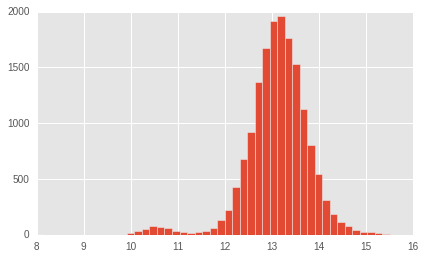

In [122]:
plt.clf()
plt.hist(np.concatenate(f338a_pnas)[:,-3], bins=50, range=[8,16])
plt.show()

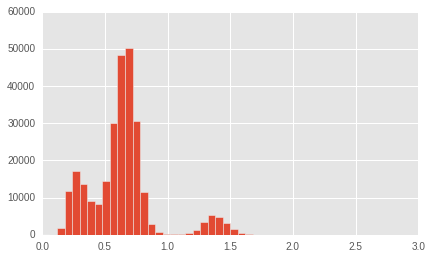

In [121]:
plt.clf()
plt.hist(np.concatenate(suf_pnas)[:,-7], bins=50, range=[0,3])
plt.show()

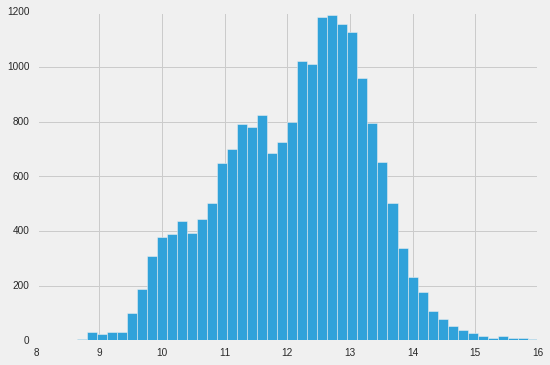

In [85]:
plt.clf()
plt.hist(suf_pnas_resampled[:,-3],bins=50, range=[8,16])
plt.show()

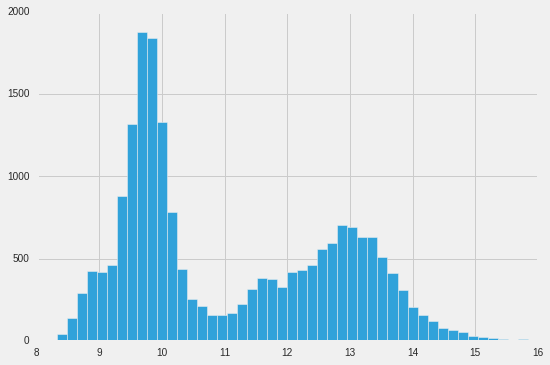

In [79]:
plt.clf()
plt.hist(bu72_pnas_resampled[:,-3],bins=50, range=[8,16])
plt.show()

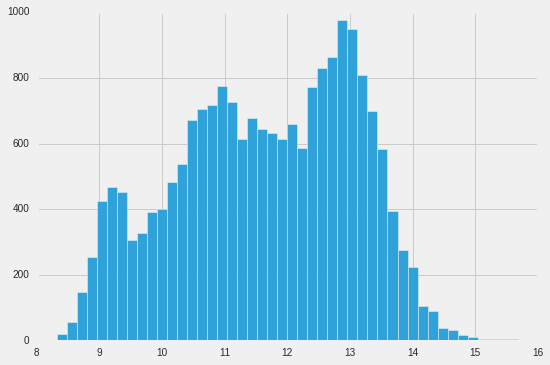

In [80]:
plt.clf()
plt.hist(apo_pnas_resampled[:,-3],bins=50, range=[8,16])
plt.show()

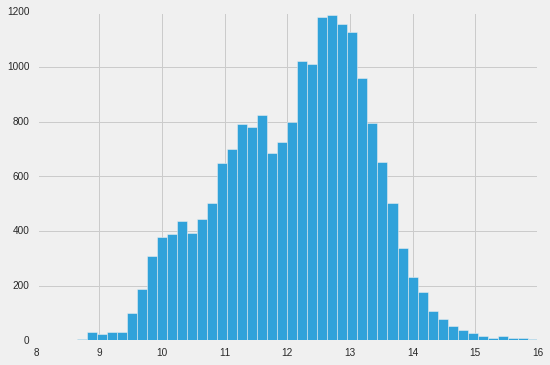

In [83]:
plt.clf()
plt.hist(suf_pnas_resampled[:,-3],bins=50, range=[8,16])
plt.show()

In [ ]:
plt.clf()
plt.hist(bu72_tica_resampled[:,-3],bins=50, range=4,6])
plt.show()

In [ ]:
plt.clf()
plt.hist(apo_tica_resampled[:,2],bins=50, range=[-4,6])
plt.show()

In [49]:

bu72_lag_time=25
prior_counts = 1e-5
ergodic_cutoff='off'
bu72_msm_dir = os.path.join(tica_dir, "bu72_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters))
#if 1==1:
if not os.path.exists(bu72_msm_dir):
    bu72_msm = build_msm(bu72_clusterer_file, bu72_lag_time, bu72_msm_dir, prior_counts, ergodic_cutoff)
else:
    bu72_msm = compat_verboseload(bu72_msm_dir)

import msm_resampled
reload(msm_resampled)
from msm_resampled import *
total_samples = 20000
num_trajs = len(bu72_trajs)
bu72_resampled_traj_to_frames_file = os.path.join(tica_dir, "bu72_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters, total_samples))
#if not os.path.exists(bu72_resampled_traj_to_frames_file):
bu72_resampled_traj_to_frames = resample_by_msm(total_samples, bu72_msm, bu72_clusters_map, num_trajs, bu72_resampled_traj_to_frames_file)
#else:
bu72_resampled_traj_to_frames = compat_verboseload(bu72_resampled_traj_to_frames_file)

bu72_pnas = compat_verboseload(bu72_pnas_file)
bu72_pnas_resampled_file = os.path.join(tica_dir, "bu72_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(bu72_pnas, bu72_resampled_traj_to_frames, bu72_pnas_resampled_file)
bu72_pnas_resampled = compat_verboseload(bu72_pnas_resampled_file)

tica_concatenated = np.concatenate(compat_verboseload(projected_features_dir))
tica_axes = [(np.min(tica_concatenated[:,i]), np.max(tica_concatenated[:,i])) for i in range(0, np.shape(tica_concatenated)[1])]

bu72_tica = compat_verboseload(bu72_tica_file)
bu72_tica_resampled_file = os.path.join(tica_dir, "bu72_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(bu72_tica, bu72_resampled_traj_to_frames, bu72_tica_resampled_file)
bu72_tica_resampled = compat_verboseload(bu72_tica_resampled_file)

bu72_clusterer = compat_verboseload(bu72_clusterer_file)
bu72_msm = compat_verboseload(bu72_msm_dir)

cluster_id_proportion_tuples = []

equilibrium_populations = bu72_msm.populations_

for cluster_id in bu72_msm.mapping_.keys():
    state_id = bu72_msm.mapping_[cluster_id]
    cluster_id_proportion_tuples.append((cluster_id,equilibrium_populations[state_id]))
cluster_id_proportion_tuples = sorted(cluster_id_proportion_tuples, key=itemgetter(1), reverse=True)
    
#plot_all_tics_and_clusters(tica_dir, bu72_tica_resampled_file, bu72_clusterer_file, lag_time, tic_range=range(0,n_components), main = "bu72_MSM_Reweighted", label = "cluster_id", active_cluster_ids = [c[0] for c in cluster_id_proportion_tuples[0:100]], intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=False, axes=tica_axes)

#plot_columns(tica_dir, bu72_tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_bu72_MSM_", tICA = False, scale = 1.0, refcoords_file = ref_tica_coords, axes=tica_axes, concatenate=False, reshape=False)

Found number to sample per cluster based on equilibrium proporrtions.
Obtained random (trajectory, frame) pairs based on equilibrium populations
Rearranged equilibrium sampled frames based on trajectories
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_msm_lag-time25_prior-counts1e-05_clusters1000_resampled_20000.h5"... (<class 'dict'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_pnas_msm_lag-time25_prior-counts1e-05_clusters1000_resampled_20000.h5"... (<class 'numpy.ndarray'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_tica_msm_lag-time25_prior-counts1e-05_clusters1000_resampled_20000.h5"..

In [ ]:
plt.clf()
plt.hist(np.concatenate(bu72_pnas)[:,8], bins=50)
plt.show()

In [ ]:
bu72_pnas_averages = calculate_cluster_averages_per_feature(bu72_clusterer, bu72_pnas)
len(sorted(list(set(np.concatenate(bu72_clusterer.labels_)))))
print(np.sum(bu72_msm.populations_[np.concatenate(bu72_msm.transform(np.where(bu72_pnas_averages[:,8] > 12.)[0]))]))
print(np.sum(bu72_msm.populations_[np.concatenate(bu72_msm.transform(np.where(bu72_pnas_averages[:,8] < 12.)[0]))]))

In [ ]:
apo_pnas_averages = calculate_cluster_averages_per_feature(apo_clusterer, apo_pnas)
len(sorted(list(set(np.concatenate(apo_clusterer.labels_)))))
print(np.sum(apo_msm.populations_[np.concatenate(apo_msm.transform(np.where(apo_pnas_averages[:,8] > 12.)[0]))]))
print(np.sum(apo_msm.populations_[np.concatenate(apo_msm.transform(np.where(apo_pnas_averages[:,8] < 12.)[0]))]))

In [ ]:
apo_pnas_averages = calculate_cluster_averages_per_feature(apo_clusterer, apo_pnas)
sorted(list(set(np.concatenate(apo_clusterer.labels_))))

In [ ]:
np.sum(apo_msm.populations_[np.concatenate(apo_msm.partial_transform(list(set(np.concatenate(apo_clusterer.labels_)))))])

In [ ]:
apo_msm.partial_transform(list(set(np.concatenate(apo_clusterer.labels_))))

In [ ]:
apo_msm.partial_transform(np.array(list(set(np.concatenate(apo_clusterer.labels_)))))

In [ ]:
plt.clf()
plt.hist(np.concatenate(apo_pnas)[:,8], bins=50, range=[6,18.])
plt.show()

In [ ]:
graph_file = "%s/bu72_clusters_%d_msm_lag_time%d_graph.graphml" % (tica_dir, n_clusters, bu72_lag_time)
bu72_tica_averages = calculate_cluster_averages_per_feature(bu72_clusterer, bu72_tica)
bu72_cluster_attributes = {}
for i, title in enumerate(["tIC.%d" %i for i in range(1,n_components+1)]):
    bu72_cluster_attributes[title] = bu72_tica_averages[:,i]

bu72_msm_attributes = {'eq_pops' : bu72_msm.populations_}
construct_graph(bu72_msm_dir, bu72_clusterer_file, n_clusters, 5, 5, graph_file, inactive = None, active = None, pnas_clusters_averages = None, tica_clusters_averages = None, docking=None, macrostate = None, cluster_attributes=bu72_cluster_attributes, msm_attributes=bu72_msm_attributes)

In [ ]:
suf_msm_dir

In [50]:
suf_lag_time=25
prior_counts = 1e-5
ergodic_cutoff='off'
suf_msm_dir = os.path.join(tica_dir, "suf_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(suf_lag_time, str(prior_counts), n_clusters))
if not os.path.exists(suf_msm_dir):
    suf_msm = build_msm(suf_clusterer_file, suf_lag_time, suf_msm_dir, prior_counts, ergodic_cutoff)
else:
    suf_msm = compat_verboseload(suf_msm_dir)

import msm_resampled
reload(msm_resampled)
from msm_resampled import *
total_samples = 20000
num_trajs = len(suf_trajs)
suf_resampled_traj_to_frames_file = os.path.join(tica_dir, "suf_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(suf_lag_time, str(prior_counts), n_clusters, total_samples))
#if not os.path.exists(suf_resampled_traj_to_frames_file):
suf_resampled_traj_to_frames = resample_by_msm(total_samples, suf_msm, suf_clusters_map, num_trajs, suf_resampled_traj_to_frames_file)
#else:
suf_resampled_traj_to_frames = compat_verboseload(suf_resampled_traj_to_frames_file)

suf_pnas = compat_verboseload(suf_pnas_file)
suf_pnas_resampled_file = os.path.join(tica_dir, "suf_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(suf_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(suf_pnas, suf_resampled_traj_to_frames, suf_pnas_resampled_file)
suf_pnas_resampled = compat_verboseload(suf_pnas_resampled_file)

tica_concatenated = np.concatenate(compat_verboseload(projected_features_dir))
tica_axes = [(np.min(tica_concatenated[:,i]), np.max(tica_concatenated[:,i])) for i in range(0, np.shape(tica_concatenated)[1])]

suf_tica = compat_verboseload(suf_tica_file)
suf_tica_resampled_file = os.path.join(tica_dir, "suf_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(suf_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(suf_tica, suf_resampled_traj_to_frames, suf_tica_resampled_file)
suf_tica_resampled = compat_verboseload(suf_tica_resampled_file)

suf_clusterer = compat_verboseload(suf_clusterer_file)
suf_msm = compat_verboseload(suf_msm_dir)

cluster_id_proportion_tuples = []

equilibrium_populations = suf_msm.populations_

for cluster_id in suf_msm.mapping_.keys():
    state_id = suf_msm.mapping_[cluster_id]
    cluster_id_proportion_tuples.append((cluster_id,equilibrium_populations[state_id]))
cluster_id_proportion_tuples = sorted(cluster_id_proportion_tuples, key=itemgetter(1), reverse=True)
    
#plot_all_tics_and_clusters(tica_dir, suf_tica_resampled_file, suf_clusterer_file, lag_time, tic_range=range(0,n_components), main = "suf_MSM_Reweighted", label = "cluster_id", active_cluster_ids = [c[0] for c in cluster_id_proportion_tuples[0:100]], intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=False, axes=tica_axes)

#plot_columns(tica_dir, suf_tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_suf_MSM_", tICA = False, scale = 1.0, refcoords_file = ref_tica_coords, axes=tica_axes, concatenate=False, reshape=False)

Found number to sample per cluster based on equilibrium proporrtions.
Obtained random (trajectory, frame) pairs based on equilibrium populations
Rearranged equilibrium sampled frames based on trajectories
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_msm_lag-time25_prior-counts1e-05_clusters1000_resampled_20000.h5"... (<class 'dict'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_pnas_msm_lag-time25_prior-counts1e-05_clusters1000_resampled_20000.h5"... (<class 'numpy.ndarray'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_tica_msm_lag-time25_prior-counts1e-05_clusters1000_resampled_20000.h5"... (

In [ ]:
suf_resampled_traj_to_frames_file

In [ ]:
plot_columns(tica_dir, apo_pnas_resampled_file, titles = sorted(feature_name_residues_dict.keys()), main = "mOR_Apo_MSM_", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False, reshape=True)

In [ ]:
bu72_lag_time=25
prior_counts = 0.0
bu72_msm_dir = os.path.join(tica_dir, "bu72_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters))
if not os.path.exists(bu72_msm_dir):
    bu72_msm = build_msm(bu72_clusterer_file, bu72_lag_time, bu72_msm_dir, prior_counts)
else:
    bu72_msm = compat_verboseload(bu72_msm_dir)
bu72_msm.timescales_

In [ ]:
fixed_assignments = dict()
for i, traj in enumerate(bu72_clusterer.labels_):
    fixed_assignments[i] = bu72_msm.transform(traj)

In [ ]:
fixed_assignments[0]

In [ ]:
print("hello")

In [ ]:
def pop_vs_counts(msm_obj, fixed_assignments, ax,**kwargs):

    pop_count_vect=[]
    for i in range(msm_obj.n_states_):
        pop_count_vect.append(np.sum([np.count_nonzero(fixed_assignments[j]==i)
                                      for j in fixed_assignments.keys()]))
    pop_count_vect = pop_count_vect/np.sum(pop_count_vect)
    ax.errorbar(np.log10(msm_object.populations_),np.log10(pop_count_vect),**kwargs)
    ax.plot([0,-6],[0,-6])
    ax.set_ylim([-6,0])
    ax.set_xlim([-6,0])
    ax.set_xlabel(" MSM Population",size=16)
    ax.set_ylabel("Counts Population",size=16)
    return pop_count_vect
f=figure()
ax=f.add_subplot(1,1,1)
pop_count_vect = pop_vs_counts(bu72_msm, fixed_assignments, ax fmt='o', color='r',label="RCSB-ASP")
ax.legend(loc='best',prop={'size':12})

In [ ]:
total_samples = 20000
num_trajs = len(bu72_trajs)
bu72_resampled_traj_to_frames_file = os.path.join(tica_dir, "bu72_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters, total_samples))
if not os.path.exists(bu72_resampled_traj_to_frames_file):
    bu72_resampled_traj_to_frames = resample_by_msm(total_samples, bu72_msm, bu72_clusters_map, num_trajs, bu72_resampled_traj_to_frames_file)
else:
    bu72_resampled_traj_to_frames = compat_verboseload(bu72_resampled_traj_to_frames_file)

In [ ]:
bu72_resampled_traj_to_frames_file

In [ ]:
bu72_pnas = compat_verboseload(bu72_pnas_file)
bu72_pnas_resampled_file = os.path.join(tica_dir, "bu72_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(bu72_pnas, bu72_resampled_traj_to_frames, bu72_pnas_resampled_file)
bu72_pnas_resampled = compat_verboseload(bu72_pnas_resampled_file)

In [ ]:
bu72_tica = compat_verboseload(bu72_tica_file)
bu72_tica_resampled_file = os.path.join(tica_dir, "bu72_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(bu72_tica, bu72_resampled_traj_to_frames, bu72_tica_resampled_file)
bu72_tica_resampled = compat_verboseload(bu72_tica_resampled_file)

In [ ]:
bu72_clusterer = compat_verboseload(bu72_clusterer_file)
bu72_msm = compat_verboseload(bu72_msm_dir)

cluster_id_proportion_tuples = []

equilibrium_populations = bu72_msm.populations_

for cluster_id in bu72_msm.mapping_.keys():
    state_id = bu72_msm.mapping_[cluster_id]
    cluster_id_proportion_tuples.append((cluster_id,equilibrium_populations[state_id]))
cluster_id_proportion_tuples = sorted(cluster_id_proportion_tuples, key=itemgetter(1), reverse=True)
    
plot_all_tics_and_clusters(tica_dir, bu72_tica_resampled_file, bu72_clusterer_file, lag_time, tic_range=range(0,10), main = "bu72_MSM_Reweighted", label = "cluster_id", active_cluster_ids = [c[0] for c in cluster_id_proportion_tuples[0:100]], intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=False, axes=tica_axes)

In [ ]:
bu72_pnas_file

In [ ]:
analysis_dir

In [ ]:
tica_resampled = np.vstack([compat_verboseload(bu72_pnas_resampled_file)[::1,], compat_verboseload(apo_pnas_resampled_file)[::1,], compat_verboseload(suf_pnas_resampled_file)[::1,]])
mins = np.min(tica_resampled, axis=0)
maxs = np.max(tica_resampled, axis=0)
stds = np.std(tica_resampled, axis=0)
custom_lims = [[mins[i] - .5*stds[i], maxs[i] + .5*stds[i]] for i in range(0,len(mins))]

In [ ]:
ref_pnas = load_file("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5")
ref_pnas = np.hstack([np.array(x).T for x in ref_pnas])

In [52]:
def get_features(features_dir):
    feature_files = get_trajectory_files(features_dir, ".dataset")
    features = np.vstack([load_file(f) for f in feature_files])
    print(features.shape)
    return features

ref_pp_features = pd.DataFrame(get_features(ref_features_dir), columns=feature_names)

ref_pp_tica = pd.read_csv(ref_tica_coords, header=None).values
#ref_pp_tica.columns = ["mOR tIC.%d" %i for i in range(1,ref_pp_tica.shape[1])]

ref_pnas = load_file("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5")
ref_pnas = np.hstack([np.array(x).T for x in ref_pnas])

#ref_pnas = pd.DataFrame(ref_pnas, columns=sorted(feature_name_residues_dict.keys()))

#ref_features = pd.concat([ref_pp_features*10., ref_lp_features*10., ref_pp_tica, ref_lp_tica, ref_pnas], axis=1)

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/4dkl_R_for_conformation.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/5c1m.dataset
(2, 2408)
loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5


In [ ]:
coords_bounds_dict = {"tIC.4": [(8.0, 10.), (12., 15.)]}
all_traj_files = get_trajectory_files(traj_dir, traj_ext)
trajs_to_watch = reaction_coordinate_sampler([all_traj_files[i] for i in bu72_trajs], ".h5", [t.values for t in all_traj_features], 
                            all_traj_features[0].columns.values.tolist(), coords_bounds_dict, 
                            "%s/trajs_to_watch.csv" %pp_tica_dir)

In [ ]:
ref_pp_tica

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
jointplots(bu72_pnas_resampled[::1,:], analysis_dir, titles = sorted(feature_name_residues_dict.keys()), main = "mOR_BU72_MSM_%d_Clusters" %n_clusters, refcoords = ref_pnas, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=3., custom_lims=custom_lims, n_levels=15, n_pts=200j, parallel=True, remake=True)

In [ ]:
ref_pnas

In [ ]:
jointplots(apo_pnas_resampled[::1,:], analysis_dir, titles = sorted(feature_name_residues_dict.keys()), main = "mOR_APO_MSM_%d_Clusters" %n_clusters, refcoords=ref_pnas, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=3., custom_lims=custom_lims, n_levels=10, remake=True)

In [ ]:
jointplots(suf_pnas_resampled[::1,:], analysis_dir, titles = sorted(feature_name_residues_dict.keys()), main = "mOR_SUF_MSM_%d_Clusters" %n_clusters, refcoords=ref_pnas, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=3., custom_lims=custom_lims, n_levels=10, remake=True)

In [54]:
tica_resampled = np.vstack([compat_verboseload(bu72_tica_resampled_file)[::1,], compat_verboseload(apo_tica_resampled_file)[::1,], compat_verboseload(suf_tica_resampled_file)[::1,]])
mins = np.min(tica_resampled, axis=0)
maxs = np.max(tica_resampled, axis=0)
stds = np.std(tica_resampled, axis=0)
custom_lims = [[mins[i] - 1.*stds[i], maxs[i] + 1.*stds[i]] for i in range(0,len(mins))]


In [ ]:
custom_lims

In [ ]:
print(custom_lims)
print(custom_lims[3][1])

In [55]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
refcoords_jointplots_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(refcoords_jointplots_dir):
    os.makedirs(refcoords_jointplots_dir)
jointplots(compat_verboseload(bu72_tica_resampled_file)[::1,:], refcoords_jointplots_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "BU72 MSM", refcoords=ref_pp_tica, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=10, min_density=None, max_diff=8., custom_lims=custom_lims, n_pts=200j, n_levels=15, remake=False, parallel=False, max_i=1)
jointplots(compat_verboseload(apo_tica_resampled_file)[::1,:], refcoords_jointplots_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "Apo MSM", refcoords=ref_pp_tica, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=10, min_density=None, max_diff=8., custom_lims=custom_lims, n_pts=200j, n_levels=15, remake=False, parallel=False, max_i=1)
jointplots(compat_verboseload(suf_tica_resampled_file)[::1,:], refcoords_jointplots_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "Sufentanil MSM", refcoords=ref_pp_tica, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=10, min_density=None, max_diff=8., custom_lims=custom_lims, n_pts=200j, n_levels=15, remake=False, parallel=False, max_i=1)



Making delta G plots.
1
2
3
4
5
6
(2, 19984)
Computed 2D KDE
min_density=0.0
Computed Density. Now plotting.
(0.0, 8.0)
[[ 0.1997732   0.73737192]
 [-0.27086734  0.45005798]]
7
(2, 19984)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 8.0)
[[ 0.1997732  -2.846076  ]
 [-0.27086734  0.34059189]]
8
(2, 19984)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 8.0)
[[ 0.1997732  -0.77531983]
 [-0.27086734  0.15601567]]
9
(2, 19984)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 8.0)
[[ 0.1997732  -0.86493743]
 [-0.27086734  0.67270475]]
Done plotting columns
Making delta G plots.
1
(2, 19998)
Computed 2D KDE
min_density=0.0
Computed Density. Now plotting.
(0.0, 8.0)
[[ 0.1997732   1.16827855]
 [-0.27086734 -0.90431764]]
2
(2, 19998)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 8.0)
[[ 0.1997732  -0.12336551]
 [-0.27086734 -0.51214134]]
3
(2, 19998)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 8.0)
[[ 0.1997732  -1.66948062]
 [-0.27086734  0.09047833]]
4
(

In [ ]:
ref_pp_tica

In [ ]:
np.concatenate(bu72_tica).shape

In [ ]:
np.concatenate(apo_tica).shape

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
jointplots(compat_verboseload(bu72_tica_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "BU72 MSM", refcoords=None, axes=None, data_j=bu72_pnas_resampled, titles_j=sorted(feature_name_residues_dict.keys()), reshape=False, max_tIC=10, min_density=None, max_diff=8., custom_lims=None, remake=True)
#jointplots(compat_verboseload(apo_tica_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "Apo MSM", refcoords=None, axes=None, data_j=apo_pnas_resampled, titles_j=sorted(feature_name_residues_dict.keys()), reshape=False, max_tIC=10, min_density=None, max_diff=8., custom_lims=None)
#jointplots(compat_verboseload(suf_tica_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "Sufentanil MSM", refcoords=None, axes=None, data_j=bu72_pnas_resampled, titles_j=sorted(feature_name_residues_dict.keys()), reshape=False, max_tIC=10, min_density=None, max_diff=8., custom_lims=None)

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *


In [ ]:
#sample_tIC_regions_silverman(np.concatenate(compat_verboseload(projected_features_dir))[::100,:], analysis_dir)
#get_kde_mins_and_maxes(np.concatenate(compat_verboseload(projected_features_dir))[::100,:], analysis_dir)
sample_kde_maxima(compat_verboseload(projected_features_dir), analysis_dir, trajs)

In [ ]:
jointplots(compat_verboseload(apo_tica_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "Apo MSM", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=5, min_density=None, max_diff=5., custom_lims=custom_lims)

In [ ]:
plot_columns(tica_dir, bu72_pnas_resampled_file, titles = sorted(feature_name_residues_dict.keys()), main = "mOR_BU72_MSM_", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False, reshape=True)

In [ ]:
#bu72_tica = compat_verboseload(bu72_tica_file)
#bu72_tica_resampled_file = os.path.join(tica_dir, "bu72_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled.h5" %(lag_time, str(prior_counts), n_clusters))
#resample_features_by_msm_equilibirum_pop(bu72_tica, bu72_resampled_traj_to_frames, bu72_tica_resampled_file)
#bu72_tica_resampled = compat_verboseload(bu72_tica_resampled_file)
plot_columns(tica_dir, bu72_tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_BU72_MSM_", tICA = False, scale = 1.0, refcoords_file = ref_tica_coords, axes=tica_axes, concatenate=False, reshape=True)

In [ ]:
bu72_clusterer = compat_verboseload(bu72_clusterer_file)
bu72_msm = compat_verboseload(bu72_msm_dir)

cluster_id_proportion_tuples = []

equilibrium_populations = bu72_msm.populations_

for cluster_id in bu72_msm.mapping_.keys():
    state_id = bu72_msm.mapping_[cluster_id]
    cluster_id_proportion_tuples.append((cluster_id,equilibrium_populations[state_id]))
cluster_id_proportion_tuples = sorted(cluster_id_proportion_tuples, key=itemgetter(1), reverse=True)

#plot_all_tics_and_clusters(tica_dir, bu72_tica_resampled_file, bu72_clusterer_file, lag_time, tic_range=[0,3], main = "BU72_MSM_Reweighted", label = "cluster_id", active_cluster_ids = [c[0] for c in cluster_id_proportion_tuples[0:100]], intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=False, axes=tica_axes)


In [ ]:
len(dview)

In [126]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters= 1000
samples_dir = "%s/bu72_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/bu72_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(bu72_clusterer_file, bu72_tica_file, [traj_files[i] for i in bu72_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=True, lig_name="LIG")

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_clusterer_1000clusters_1samples_samples_kdtree
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_clusterer1000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_tica.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_clusterer1000.h5"...
[[149 356]
 [379 392]
 [468 474]
 ..., 
 [218 185]
 [375 365]
 [294 237]]
1000
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_c

In [127]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters= 1000
samples_dir = "%s/suf_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/suf_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(suf_clusterer_file, suf_tica_file, [traj_files[i] for i in suf_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=True, lig_name="LIG")

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_clusterer_1000clusters_1samples_samples_kdtree
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_clusterer1000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_tica.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_clusterer1000.h5"...
[[494 114]
 [218 323]
 [ 38 170]
 ..., 
 [726 453]
 [714  48]
 [615 459]]
1000
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutof

In [67]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters= 100
samples_dir = "%s/all_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/all_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(clusterer_dir, projected_features_dir, traj_files, 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=None, parallel=False, lig_name="NON")

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/all_clusterer_100clusters_1samples_samples_kdtree
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/clusterer_100clusters.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/clusterer_100clusters.h5"...
[[ 965    5]
 [ 760  289]
 [1444   39]
 [1667  224]
 [ 485   54]
 [ 339  428]
 [ 669  179]
 [ 783  303]
 [  99   47]
 [ 835   30]
 [1027  332]
 [ 354  101]
 [1708 

In [68]:
samples_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/all_clusterer_100clusters_1samples_samples_kdtree'

In [ ]:
get_trajectory_files(traj_dir, traj_ext)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 5
n_clusters=250
samples_dir = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)

sample_from_clusterer(apo_clusterer_file, apo_tica_file, [traj_files[i] for i in apo_trajs],
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=None, parallel=True, lig_name="LIG")

In [ ]:
traj_files

In [ ]:
feature_name_residues_dict.keys()

In [ ]:

np.shape(apo_pnas_resampled)
msm_dir = os.path.join(tica_dir, "msm_lag-time%d_prior-counts%s_clusters%d_analysis" %(lag_time, str(prior_counts), n_clusters))
if not os.path.exists(msm_dir): os.makedirs(msm_dir)

#plot_columns(msm_dir, apo_pnas_resampled_file, titles = feature_name_residues_dict.keys(), main = "Apo-mOR", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False)

In [ ]:
import pip

def install(package):
    pip.main(['install', package])
    
install("moviepy")

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

for i, traj in enumerate(get_trajectory_files(traj_dir, traj_ext)):
    if "apo_rep_68." in traj:
        index=i
        break

jointplot(apo_pnas_resampled[::10,[6,3]], "%s/test.pdf" %msm_dir, trajectory=apo_pnas[index][::1,[6,3]], 
          titles=["TM6 to TM3 distance", "RMSD of NPxxY to Inactive"], main = "mOR Activation Pathway", 
          video_file = "%s/apo_68.mp4" %msm_dir, custom_xlim=[4.0, 16.0], custom_ylim= [0.0, 1.0])
#test("%s/test2.mp4" %msm_dir)

In [ ]:
build_msm(bu72_clusterer_file, lag_time, msm_model_dir)
build_msm(apo_clusterer_file, lag_time, msm_model_dir)

In [ ]:
tics_1_5_file = os.path.join(tica_dir, "tICs_1_5.h5")
tics = load_file(projected_features_dir)
tics_1_5 = [x[:,range(1,5)] for x in tics]
verbosedump(tics_1_5, tics_1_5_file)

clusterer300_clusters = os.path.join(tica_dir, "clusterer300_clusters_tICs1_5.h5")
cluster_minikmeans(tica_dir, tics_1_5_file, traj_dir, n_clusters=300, clusterer_dir=clusterer300_clusters)

In [ ]:
len(dview)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters = 300

traj_files = get_trajectory_files(traj_dir, traj_ext)
featurized_trajectories = [traj_files[i] for i in feature_indices]
suf_traj_files = [t for t in featurized_trajectories if "suf" in t]
reduced_clusterer = compat_verboseload(clusterer300_clusters)
suf_reduced_clusterer_file = "%s/suf_reduced_clusterer.h5" %tica_dir

suf_reduced_tica_file = "%s/suf_reduced_tica.h5" %tica_dir
suf_reduced_tica = [x[:,range(1,5)] for x in suf_tica]
suf_reseeded_dir = "%s/suf_reseeded_samples" %tica_dir
if not os.path.exists(suf_reseeded_dir):
    os.makedirs(suf_reseeded_dir)
verbosedump(suf_reduced_tica, suf_reduced_tica_file)

suf_reduced_clusters = [reduced_clusterer.labels_[i] for i in suf_trajs]
suf_reduced_clusterer = copy.deepcopy(reduced_clusterer)
suf_reduced_clusterer.labels_ = suf_reduced_clusters
verbosedump(suf_reduced_clusterer, suf_reduced_clusterer_file)
#reseed_from_clusterer(suf_reduced_clusterer_file, "suf", suf_reseeded_dir, suf_reduced_tica_file, suf_traj_files)


samples_dir = "%s/suf_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
reseed_dir = "%s/suf_clusterer_%dclusters_%dsamples_samples_kdtree_reseed" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/suf_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
if not os.path.exists(reseed_dir): os.makedirs(reseed_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(suf_reduced_clusterer_file, suf_reduced_tica_file, [traj_files[i] for i in suf_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=False, lig_name="LIG", reseed_dir = reseed_dir)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters = 300

traj_files = get_trajectory_files(traj_dir, traj_ext)
featurized_trajectories = [traj_files[i] for i in feature_indices]
bu72_traj_files = [t for t in featurized_trajectories if "bu72" in t]
reduced_clusterer = compat_verboseload(clusterer300_clusters)
bu72_reduced_clusterer_file = "%s/bu72_reduced_clusterer.h5" %tica_dir

bu72_reduced_tica_file = "%s/bu72_reduced_tica.h5" %tica_dir
bu72_reduced_tica = [x[:,range(1,5)] for x in bu72_tica]
bu72_reseeded_dir = "%s/bu72_reseeded_samples" %tica_dir
if not os.path.exists(bu72_reseeded_dir):
    os.makedirs(bu72_reseeded_dir)
verbosedump(bu72_reduced_tica, bu72_reduced_tica_file)

bu72_reduced_clusters = [reduced_clusterer.labels_[i] for i in bu72_trajs]
bu72_reduced_clusterer = copy.deepcopy(reduced_clusterer)
bu72_reduced_clusterer.labels_ = bu72_reduced_clusters
verbosedump(bu72_reduced_clusterer, bu72_reduced_clusterer_file)
#reseed_from_clusterer(bu72_reduced_clusterer_file, "bu72", bu72_reseeded_dir, bu72_reduced_tica_file, bu72_traj_files)


samples_dir = "%s/bu72_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
reseed_dir = "%s/bu72_clusterer_%dclusters_%dsamples_samples_kdtree_reseed" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/bu72_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
if not os.path.exists(reseed_dir): os.makedirs(reseed_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(bu72_reduced_clusterer_file, bu72_reduced_tica_file, [traj_files[i] for i in bu72_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=False, lig_name="LIG", reseed_dir = reseed_dir)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters = 300

traj_files = get_trajectory_files(traj_dir, traj_ext)
featurized_trajectories = [traj_files[i] for i in feature_indices]
apo_traj_files = [t for t in featurized_trajectories if "apo" in t]
reduced_clusterer = compat_verboseload(clusterer300_clusters)
apo_reduced_clusterer_file = "%s/apo_reduced_clusterer.h5" %tica_dir

apo_reduced_tica_file = "%s/apo_reduced_tica.h5" %tica_dir
apo_reduced_tica = [x[:,range(1,5)] for x in apo_tica]
apo_reseeded_dir = "%s/apo_reseeded_samples" %tica_dir
if not os.path.exists(apo_reseeded_dir):
    os.makedirs(apo_reseeded_dir)
verbosedump(apo_reduced_tica, apo_reduced_tica_file)

apo_reduced_clusters = [reduced_clusterer.labels_[i] for i in apo_trajs]
apo_reduced_clusterer = copy.deepcopy(reduced_clusterer)
apo_reduced_clusterer.labels_ = apo_reduced_clusters
verbosedump(apo_reduced_clusterer, apo_reduced_clusterer_file)
#reseed_from_clusterer(apo_reduced_clusterer_file, "apo", apo_reseeded_dir, apo_reduced_tica_file, apo_traj_files)


samples_dir = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
reseed_dir = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree_reseed" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
if not os.path.exists(reseed_dir): os.makedirs(reseed_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(apo_reduced_clusterer_file, apo_reduced_tica_file, [traj_files[i] for i in apo_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=False, lig_name="LIG", reseed_dir = reseed_dir)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *
traj_files = get_trajectory_files(traj_dir, traj_ext)
featurized_trajectories = [traj_files[i] for i in feature_indices]
oxy_traj_files = [t for t in featurized_trajectories if "oxy" in t]
reduced_clusterer = compat_verboseload(clusterer300_clusters)
oxy_reduced_clusterer_file = "%s/oxy_reduced_clusterer.h5" %tica_dir

oxy_reduced_tica_file = "%s/oxy_reduced_tica.h5" %tica_dir
oxy_reduced_tica = [x[:,range(1,10)] for x in oxy_tica]
verbosedump(oxy_reduced_tica, oxy_reduced_tica_file)

oxy_reduced_clusters = [reduced_clusterer.labels_[i] for i in oxy_trajs]
oxy_reduced_clusterer = copy.deepcopy(reduced_clusterer)
oxy_reduced_clusterer.labels_ = oxy_reduced_clusters
verbosedump(oxy_reduced_clusterer, oxy_reduced_clusterer_file)
reseed_from_clusterer(oxy_reduced_clusterer_file, "oxy", tica_dir, oxy_reduced_tica_file, oxy_traj_files)

In [ ]:
closest_indices = find_closest_indices_to_cluster_center(tics_1_3_file, clusterer16_clusters)

In [ ]:
closest_indices

In [ ]:
from scipy.stats import gamma 
x = np.linspace(0.,16.0, 100)
y = gamma.pdf(x, 5.0, loc=8.0, scale=1)
plt.plot(x,y)

In [ ]:
from scipy.stats import gamma 
x = np.linspace(0.,16.0, 100)
y = gamma.pdf(x, 3.0, loc=8.0, scale=0.4)
plt.plot(x,y)
plt.show()

In [ ]:
reseed_from_clusterer(oxy_clusterer_file, "oxy", tica_dir, oxy_tica_file, [trajs[i] for i in oxy_trajs])

In [ ]:
min_pop = [3, 4, 6, 8, 9, 26, 29, 30, 31, 32, 33, 39, 41, 43, 52, 55]


In [ ]:
plot_all_tics_and_clusters(tica_dir, oxy_tica_file, oxy_clusterer_file, lag_time, tic_range=range(0,5), main = "Oxy_Reseeds", label = "cluster_id", active_cluster_ids = min_pop, intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=True, axes=tica_axes)